# Project Page
### Here is the link to the project page for this dataset
### https://github.com/DrGFreeman/rps-cv

In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


# Function for training visualization
### Here is a function I create to visualize the training of the model

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

# Image Preprocessing
### Here I use the data augmentation and image preprocessing from the Keras ImageDataGenerator

In [3]:
data_dir = '../input/rps-cv-images/'
augs_gen = ImageDataGenerator(
    rescale=1./255,        
    horizontal_flip=True,
    height_shift_range=.2,
    vertical_flip = True,
    validation_split = 0.2
)  

train_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size = (224,224),
    batch_size=32,
    class_mode = 'categorical',
    shuffle=True,
)

val_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation'
)



Found 2188 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


# The Model
### Here I use the pretrained mobile net.
### I used this architecture because I plan to make this into a web app
### https://keras.io/applications/#mobilenet

In [4]:
model_base = MobileNet(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0,5))
model.add(Dense(3,activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


# Callbacks
### Here I load my Keras Callbacks to monitor the training of the model
### https://keras.io/callbacks/

In [5]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

# Train The Model
### Here I train our model using fit_generator

In [6]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 50, 
    validation_data  = val_gen,
    validation_steps = 50,
    epochs = 5, 
    verbose = 1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
50/50 [==============================] - 42s 849ms/step - loss: 0.1378 - acc: 0.9746 - val_loss: 1.4859 - val_acc: 0.7345

Epoch 00001: val_loss improved from inf to 1.48587, saving model to ./base.model
Epoch 2/5
50/50 [==============================] - 33s 668ms/step - loss: 0.0265 - acc: 0.9940 - val_loss: 0.2257 - val_acc: 0.9619

Epoch 00002: val_loss improved from 1.48587 to 0.22572, saving model to ./base.model
Epoch 3/5
50/50 [==============================] - 33s 669ms/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.8406 - val_acc: 0.8996

Epoch 00003: val_loss did not improve from 0.22572
Epoch 4/5
50/50 [==============================] - 35s 698ms/step - loss: 0.0534 - acc: 0.9915 - val_loss: 0.0207 - val_acc: 0.9931

Epoch 00004: val_loss improved from 0.22572 to 0.02070, saving model to ./base.model
Epoch 5/5
50/50 [==============================] - 34s 674ms/step - loss: 0.0159 - acc: 0.9958 - val_loss: 0.0308 - va

# Model Evaluation
### Here I visualize the training results, load the best model weights, evalute the model, save the json file and h5 weights

Model Test Loss: 0.03986905461414229
Model Test Accuracy: 0.9913700190176856
Weights Saved


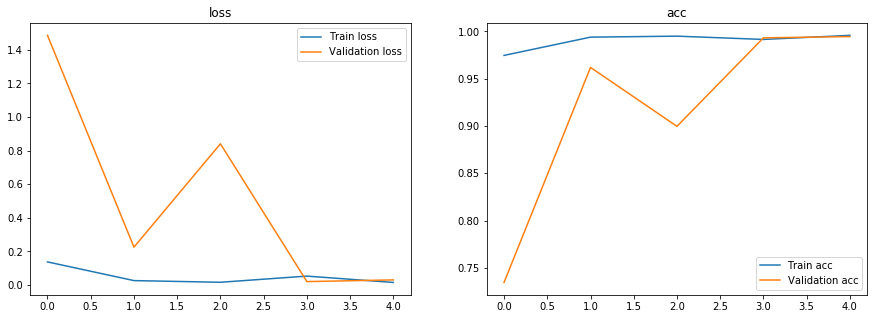

In [7]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(val_gen,steps=20)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

# TensorBoard
### Here is a script that you can use with the TensorBoard Keras Callback. It will give you a URL to view your models training results on TensorBoard

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-24 23:18:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.2.175.150, 52.22.145.207, 52.73.94.166, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.2.175.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13584026 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.95M  39.9MB/s    in 0.3s    

2019-03-24 23:18:38 (39.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13584026/13584026]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://e5c79cfa.ngrok.io


# Happy Learning!